In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from replay_buffer import ReplayBuffer
from sinewaves import (
    SINX, COSX, 
    Environment, Observation, arrange)
from investor_model_cnn import new_actor, new_critic

In [3]:
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

In [4]:
n_history = 7
n_market = 2
n_filters = 3
n_batch = 5
n_portfolio = 3

In [5]:
train_mh = (np.random.random([n_batch, n_history, n_market, 1]).astype(np.float32)-.5)/10
train_pw = np.random.random([n_batch, n_portfolio]).astype(np.float32)

In [6]:
conv_actor = new_actor(n_market, n_history, n_filters, n_portfolio)
adam = tf.optimizers.Adam(learning_rate=1e-2)
conv_actor.compile(adam, 'mse')

In [7]:
mu = conv_actor([train_mh, train_pw])
mu

<tf.Tensor: id=190, shape=(5, 3), dtype=float32, numpy=
array([[0.3493578 , 0.36570182, 0.28494033],
       [0.3475807 , 0.33142337, 0.32099593],
       [0.34694234, 0.3400881 , 0.3129696 ],
       [0.3471876 , 0.33006847, 0.32274395],
       [0.33318034, 0.33463883, 0.3321808 ]], dtype=float32)>

In [8]:
conv_critic = new_critic(n_market, n_history, n_filters, n_portfolio)

In [9]:
conv_critic([train_mh, train_pw, mu])

<tf.Tensor: id=356, shape=(5, 1), dtype=float32, numpy=
array([[-0.16601366],
       [-0.1409439 ],
       [-0.0418518 ],
       [-0.21537155],
       [-0.07842377]], dtype=float32)>

In [10]:
def heuristic_hold(x):
    """
    hold the asset with the highest total return during the most recent history period
    """
    batch_size = len(x)
    x1 = np.squeeze(x)
    sums = np.sum(x1, axis=1)
    sums_and_cash = np.hstack([np.zeros([batch_size, 1], dtype=np.float32), sums])
    max_sums = np.max(sums_and_cash, axis=-1)
    labels = ((sums_and_cash - max_sums.reshape([batch_size, 1])) == 0).astype(np.float32)
    return labels

In [11]:
labels = heuristic_hold(train_mh)

In [12]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

---
### Training the actor with heuristics

In [13]:
n_batch=256
train_mh = 10*(np.random.random([n_batch, n_history, n_market, 1]).astype(np.float32)-.5)
train_pw = np.random.random([n_batch, n_portfolio]).astype(np.float32)
eval_mh = 10*(np.random.random([100, n_history, n_market, 1]).astype(np.float32)-.5)
eval_pw = np.random.random([100, n_portfolio]).astype(np.float32)

In [14]:
def generator():
    while(True):
        train_mh = 10* (np.random.random([n_batch, n_history, n_market, 1]).astype(np.float32)-.5)
        train_pw = np.random.random([n_batch, n_portfolio]).astype(np.float32)
        x=[train_mh, train_pw]
        y=heuristic_hold(train_mh)
        yield((x,y))

In [15]:
validation_data=([eval_mh, eval_pw], heuristic_hold(eval_mh))
history = conv_actor.fit_generator(epochs = 20, generator=generator(),
                                   steps_per_epoch=10,
                                    verbose=0, 
                                   validation_data=validation_data)

In [16]:
#history = conv_actor.fit(epochs = 100,
#    x=[train_mh, train_pw], y=heuristic_hold(train_mh),
#    verbose=0, validation_data=([eval_mh, eval_pw], heuristic_hold(eval_mh)))

In [17]:
y=heuristic_hold(eval_mh)
[(conv_actor([eval_mh, eval_pw])[i].numpy(), y[i]) for i in range(5)]

[(array([4.7501936e-07, 1.4661890e-02, 9.8533767e-01], dtype=float32),
  array([0., 0., 1.], dtype=float32)),
 (array([4.0974290e-04, 3.9044602e-03, 9.9568582e-01], dtype=float32),
  array([0., 0., 1.], dtype=float32)),
 (array([2.07833417e-09, 9.99988675e-01, 1.12854705e-05], dtype=float32),
  array([0., 1., 0.], dtype=float32)),
 (array([7.2452368e-04, 7.3408238e-03, 9.9193466e-01], dtype=float32),
  array([0., 0., 1.], dtype=float32)),
 (array([2.0728344e-21, 1.0000000e+00, 1.0783675e-20], dtype=float32),
  array([0., 1., 0.], dtype=float32))]

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

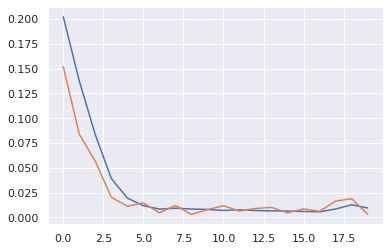

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [20]:
def plot_behaviour(actor, env, length):
    from copy import deepcopy
    env = deepcopy(env)
    wealth = []
    sin = []
    cos = []
    psin = []
    pcos = []
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, actor.n_portfolio)
    for i in range(length):
        action = actor([mh, pw]).numpy()[0]
        obs = env.step(action)
        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
        pw = pw.reshape(1, actor.n_portfolio)
        wealth.append(env.wealth()/1e8)
        sin.append(obs.s[0][-1][0])
        cos.append(obs.s[0][-1][1])
        psin.append(action[1]/100)
        pcos.append(action[2]/100)

    plt.plot(sin)
    plt.plot(cos)
    plt.plot(psin)
    plt.plot(pcos)
    plt.plot(wealth);

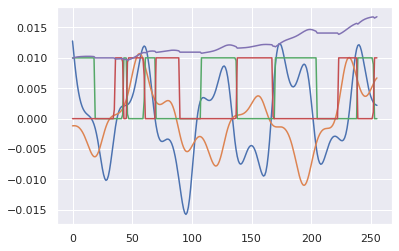

In [21]:
N_M = 2
N_H = 7
N_P = 3
LENGTH=256
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
plot_behaviour(conv_actor, env, LENGTH)

We'll see that the training with the heuristic expert does the job. It learned to hold the assets with the highest returns. Hence, we can expect the actor to learn by itself, provided that the DDPG algorithm does produce sufficiently high quality signals. Observe, however, that the training took 20 epochs with 10 batches (steps) of 256 observations, i.e. 51'200 samples to converge to that level of expertise that we can see in the above chart. It'll certainly take more samples to learn the same accuracy from trial and error. And the training generally takes longer in the DDPG setup, for it can unfortunately not use the GPUs as efficient as the minibatch gradient descent does.

# DDPG

In [22]:
def longterm_exp_return(env, actor, action, duration):
    """
    This function takes 'duration' steps in a copy of the environment using 
    the same action. Use it to compare the long term promise of a new set of 
    portfolio weights with the existing portfolio weights. And only change 
    the portfolio if the new weights have a more promising outlook. Note that 
    this little 'cheat' makes the algorithm model-based!
    """
    from copy import deepcopy
    env = deepcopy(env)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, N_P)

    wb = env.wealth()
    for _ in range(16):
        obs = env.step(action)
    return np.log(env.wealth() / wb)


In [32]:
N_M = 2
N_H = 7
N_P = 3
N_STEPS = 128
N_LTR = 8
N_EPISODES = 40
N_FILTERS = 4
NOISE_LEVEL = 0.6
N_BATCH = 64
GAMMA = 0.999
TAU = 0.1

In [33]:
primary_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_actor =  new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_actor.set_weights(primary_actor.get_weights())

primary_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
small_weights = [w/10 for w in primary_critic.get_weights()]
primary_critic.set_weights(small_weights)
pc_loss = tf.keras.losses.mean_squared_error
pc_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
primary_critic.compile(loss = pc_loss, optimizer=pc_optimizer)
pa_optimizer = tf.keras.optimizers.SGD(learning_rate=3e-2)

target_critic =  new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_critic.set_weights(primary_critic.get_weights())

In [34]:
rb = ReplayBuffer(N_BATCH * 2)
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
env.t = 200
#for _ in range(N_BATCH):
#    o = env.step([.4, .2, .4])
#    rb.add([o])

In [35]:
def validate(actor, env, length):
    from copy import deepcopy
    env = deepcopy(env)
    w0 = env.wealth()
    mh, pw = env.state()
    mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, actor.n_portfolio)
    for i in range(length):
        action = actor([mh, pw]).numpy()[0]
        obs = env.step(action)
        mh, pw = env.state()
        mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
        pw = pw.reshape(1, actor.n_portfolio)
    return np.log(env.wealth() / w0)

In [36]:
def dnsr(actor, env, n_steps):
    """Discounted n-step returns"""
    from copy import deepcopy
    env = deepcopy(env)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    GAMMA_N=np.array([GAMMA**i for i in range(n_steps) ])
    rewards = []
    for i in range(N_STEPS):
        action = actor([mh, pw])
        obs = env.step(action.numpy()[0])
        rewards.append(obs.r)

        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, N_H, N_M, 1)
        pw = pw.reshape(1, N_P)

    return np.matmul(GAMMA_N, np.array(rewards))

In [37]:
def n_step_target(pa, tc, ta, env):
    return dnsr(pa, env, n_steps) + GAMMA**(n_steps+1) * tc([mh, pw, ta([mh, pw])])

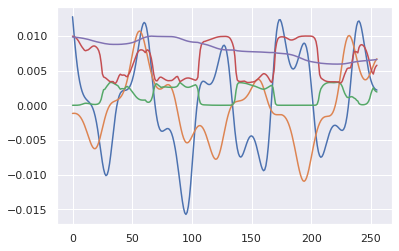

In [38]:
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
plot_behaviour(primary_actor, env, 256)

In [39]:
validate(conv_actor, env, 256), validate(primary_actor, env, 256)

(0.5165705649446377, -0.41504973802557177)

In [40]:

prev_action = None
histories = []
for episode in range(N_EPISODES):

    env = Environment(7, [4e5, 3e5, 3e5], fee=1e-2)
    Return = 0
    history={
        'actions': [],
        'target_optim': [],
        'advances': [],
        'rewards': []
    }
    histories.append(history)
    
    for step in range(N_STEPS):

        # Observe market history and current portfolio weights
        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, N_H, N_M, 1)
        pw = pw.reshape(1, N_P)

        # Decide for an action, add some noise to support exploration
        action = primary_actor([mh, pw]).numpy()[0]
        action += np.random.random([N_P]) * NOISE_LEVEL
        action /= np.sum(action)

        # Fall back to prev action if it promises more LTR given current state
        if True:
            if prev_action is not None:
                ltr = longterm_exp_return(env=env, actor=primary_actor, 
                                          action=action, duration=N_LTR)
                prev_ltr = longterm_exp_return(env=env, actor=primary_actor, 
                                               action=prev_action, duration=N_LTR)
                action = action if ltr > prev_ltr else prev_action
            prev_action = action
        
        history['actions'].append(action)
        
        # Execute action and store the results        
        observation = env.step(action)
        Return += observation.r
        history['rewards'].append(10*observation.r)
        rb.add([observation])
        
        # Sample a minibatch
        n_batch = min(N_BATCH, rb.cur_size)
        batch = rb.get_batch(min(N_BATCH, rb.cur_size))
        mh, pw, a, r, mh1, pw1 = arrange(batch)
        mh = 1000 * mh.reshape(n_batch, N_H, N_M, 1)
        mh1 = 1000 * mh1.reshape(n_batch, N_H, N_M, 1)
        
        # Compute Q-targets
        y = 10 * r + GAMMA * target_critic([mh1, pw1, target_actor([mh1, pw1])])
            
        # Update primary critic
        losses = [
            primary_critic.train_on_batch(x=[mh, pw, a], y=y)
            for _ in range(5)
        ]
        history['target_optim'].append(losses[-1] - losses[0])
        

        # Policy gradient update
        q0 = primary_critic([mh, pw, primary_actor([mh, pw])])
        for _ in range(20):
            with tf.GradientTape() as tape:
                actions = primary_actor([mh, pw])
                loss = -tf.reduce_mean(primary_critic([mh, pw, actions]))
            theta = primary_actor.trainable_variables
            gradients = tape.gradient(loss, theta)
            pa_optimizer.apply_gradients(zip(gradients, theta));
        q1 = primary_critic([mh, pw, primary_actor([mh, pw])])
        history['advances'].append(np.mean(q1)-np.mean(q0))

        
        # Update the target network
        weight_pairs = zip(target_actor.get_weights(), primary_actor.get_weights())
        new_actor_weights = [taw * ( 1 - TAU ) + paw * TAU for taw, paw in weight_pairs]
        target_actor.set_weights(new_actor_weights)

        weight_pairs = zip(target_critic.get_weights(), primary_critic.get_weights())
        new_critic_weights = [tcw * ( 1 - TAU ) + pcw * TAU for tcw, pcw in weight_pairs]
        target_critic.set_weights(new_critic_weights)
        
    #if episode % 5 == 0:
    success = validate(env=env, actor=primary_actor, length=256)
    print("Episode: %s, Training: %s, Validate: %s" %(episode, Return, success))

Episode: 0, Training: 0.06168187948060222, Validate: -0.64656234
Episode: 1, Training: 0.08703750356198725, Validate: -0.6412821
Episode: 2, Training: 0.08226505749655644, Validate: -0.6364981
Episode: 3, Training: 0.06897403361017496, Validate: -0.63513637
Episode: 4, Training: 0.09787200519235739, Validate: -0.6331406
Episode: 5, Training: 0.10428764232347021, Validate: -0.631164
Episode: 6, Training: 0.10196795048250351, Validate: -0.6296212
Episode: 7, Training: 0.11071512314447318, Validate: -0.6178658
Episode: 8, Training: 0.08208596096937981, Validate: -0.6220618
Episode: 9, Training: 0.08417015165105113, Validate: -0.62777424
Episode: 10, Training: 0.10249362412650953, Validate: -0.6170206
Episode: 11, Training: 0.09684903997185756, Validate: -0.6184382
Episode: 12, Training: 0.07765132249187445, Validate: -0.61789864
Episode: 13, Training: 0.07814803725614183, Validate: -0.6256538
Episode: 14, Training: 0.08113531140179475, Validate: -0.61797595
Episode: 15, Training: 0.077150

KeyboardInterrupt: 

In [73]:
print(histories[6]['target_optim'])
#losses

[-4.634494e-07, -5.7870056e-07, -2.2433233e-07, -3.661262e-08, -2.4901237e-07, -1.2654345e-07, -4.3655746e-09, -1.4028046e-08, -1.869048e-07, -1.3457611e-07, -3.8649887e-08, -9.831274e-08, -3.6752317e-07, -2.5972258e-07, -5.4133125e-08, -2.2933818e-08, -2.910383e-09, -1.868466e-08, -4.095491e-07, -3.2712705e-08, -5.9837475e-08, -6.6822395e-08, -7.462222e-08, -3.1432137e-08, -6.9849193e-10, -8.032657e-09, -4.656613e-09, -6.4843334e-08, -1.9790605e-09, -5.529728e-07, -1.4354009e-07, -7.159542e-08, -9.65083e-08, -2.1897722e-07, -3.1548552e-08, -1.6298145e-09, -1.2904638e-07, -1.990702e-08, -5.053589e-07, -6.624032e-08, -2.0721927e-08, -2.0419247e-07, -6.693881e-09, -1.3387762e-09, -3.183959e-08, -1.00408215e-07, -7.3341653e-09, -5.6729186e-07, -2.3806933e-08, -2.8859358e-07, -1.0296935e-07, -3.1432137e-08, -3.8708095e-08, -7.157214e-07, -6.9267116e-09, -2.6542693e-08, -1.5017577e-08, -1.7636921e-07, -9.225914e-07, -8.281786e-07, -2.7404167e-06, -8.8999514e-07, -5.03147e-07, -5.434267e-07,

In [74]:
print(histories[6]['rewards'])


[0.005998004344291985, 0.0032705679768696427, 0.004517011693678796, 0.006883158930577338, 0.003864018653985113, 0.0006007967749610543, -0.0014806889521423727, -0.0038517979555763304, -0.006101800827309489, -0.00828251417260617, -0.01043506315909326, -0.01061764545738697, -0.012560622999444604, -0.014512335183098912, -0.016464428044855595, -0.01841988880187273, -0.024970329832285643, -0.026198341511189938, -0.02716293092817068, -0.02780664013698697, -0.028140165377408266, -0.028174833860248327, -0.027916021645069122, -0.027349404990673065, -0.02643977990373969, -0.025141225196421146, -0.02340490696951747, -0.021211334969848394, -0.018575744470581412, -0.015568925300613046, -0.01231295638717711, -0.0089661730453372, -0.0056980387307703495, -0.002655739663168788, 0.001532914029667154, 0.0034481301554478705, 0.005119920242577791, 0.006624649395234883, 0.010425376240164042, 0.012678211787715554, 0.014592485968023539, 0.016765836626291275, 0.01936347922310233, 0.02253613667562604, 0.02638789

In [60]:
print(histories[20]['advances'])

[0.0, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 1.1920929e-07, 5.9604645e-08, 1.1920929e-07, 1.1920929e-07, 1.1920929e-07, 0.0, 1.1920929e-07, 0.0, 1.1920929e-07, 0.0, 0.0, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 1.1920929e-07, 5.9604645e-08, 0.0, 0.0, 1.1920929e-07, 5.9604645e-08, 0.0, 5.9604645e-08, 5.9604645e-08, 1.1920929e-07, 5.9604645e-08, 1.1920929e-07, 1.1920929e-07, 5.9604645e-08, 5.9604645e-08, 0.0, 5.9604645e-08, 0.0, 0.0, 5.9604645e-08, 1.1920929e-07, 1.1920929e-07, 5.9604645e-08, 1.1920929e-07, 0.0, 0.0, 5.9604645e-08, 5.9604645e-08, 1.1920929e-07, 5.9604645e-08, 0.0, 1.1920929e-07, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 1.1920929e-07, 1.1920929e-07, 0.0, 5.9604645e-08, 1.1920929e-07, 5.9604645e-08, 0.0, 5.9604645e-08, 0.0, 5.9604645e-08, 0.0, 5.9604645e-08, 0.0, 0.0, 1.1920929e-07, 5.9604645e-08, 5.9604645e-08, 0.0, 0.0, 5.9604645e-08, 0.0, 1.1920929e-07, 5.9604645e-08, 5.9604645e-08, 5.9604645e-08, 0.0, 1.1920929e-07, 0.0, 1.1920929e-07, 1.19

In [322]:
fresh_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
fresh_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
small_weights = [w/10 for w in fresh_critic.get_weights()]
fresh_critic.set_weights(small_weights)

In [61]:
def plot_q(actor, critic):
    env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    qvals = []
    for i in range(256):
        action = actor([mh, pw])
        qvals.append(critic([mh, pw, action]).numpy()[0][0])
        env.step(action.numpy()[0])
        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, N_H, N_M, 1)
        pw = pw.reshape(1, N_P)
    plt.plot(qvals)
    return qvals

In [450]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

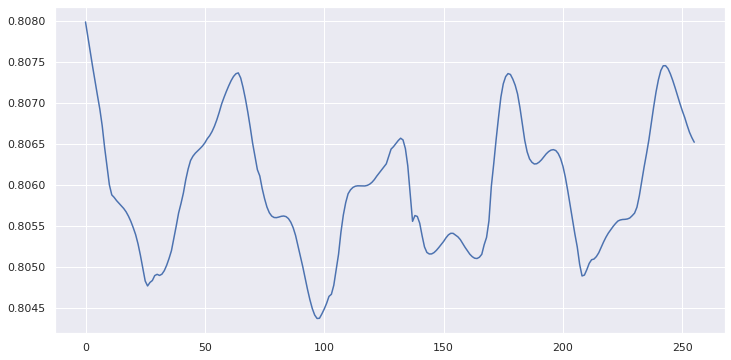

In [62]:
res = plot_q(primary_actor, primary_critic)

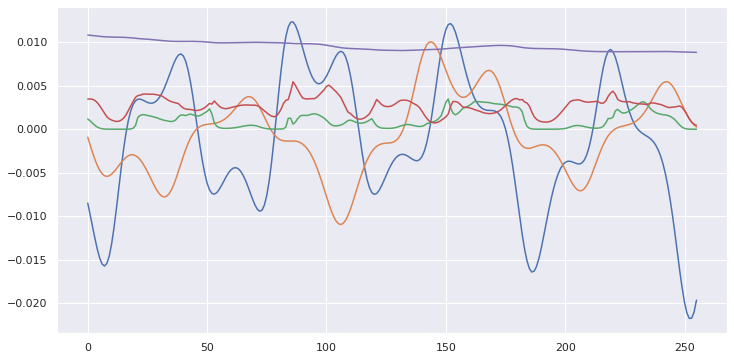

In [34]:
plot_behaviour(target_actor, env, LENGTH)

In [454]:
fresh_actor([mh, pw]).numpy()[0], primary_actor([mh, pw]).numpy()[0]

(array([0.3539165 , 0.33347127, 0.31261227], dtype=float32),
 array([0.3782775 , 0.03864956, 0.58307296], dtype=float32))

In [456]:
histories[6]['advances'][:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
print(histories[4]['advances'][:10])

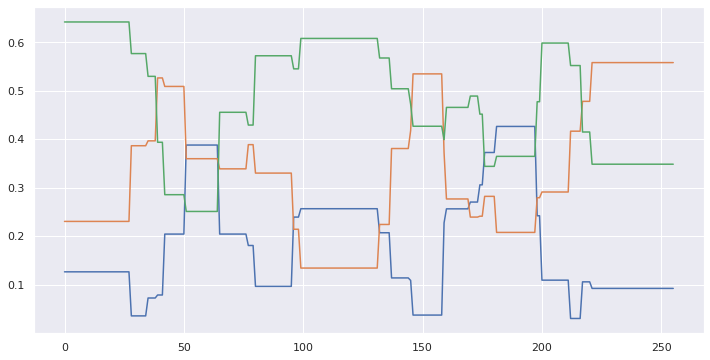

In [36]:
ah = np.array(histories[9]['actions']).T
plt.plot(ah[1]);
plt.plot(ah[2]);
plt.plot(ah[0]);

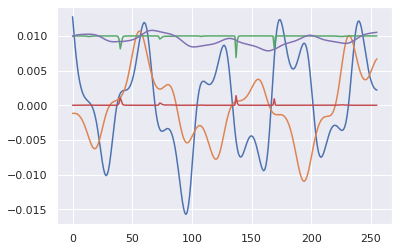

In [105]:
#primary_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
LENGTH=256
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
plot_behaviour(primary_actor, env, LENGTH)

### Multi-step returns

In [384]:
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
critic.compile(loss = loss, optimizer=optimizer)

In [388]:
GAMMA_N=np.array([GAMMA**i for i in range(3) ])
GAMMA_N

array([1.        , 0.9999    , 0.99980001])

In [402]:
n_steps = 3
dnsr(actor, critic, env, n_steps)

-0.004725434919184604

In [417]:
n_step_target(primary_actor, target_critic, target_actor, env)

<tf.Tensor: id=179014517, shape=(1, 1), dtype=float32, numpy=array([[-0.00293337]], dtype=float32)>

In [104]:
# Sample a minibatch
N_BATCH=2
n_batch = min(N_BATCH, rb.cur_size)
batch = rb.get_batch(min(N_BATCH, rb.cur_size))
mh, pw, a, r, mh1, pw1 = arrange(batch)
mh = 1000 * mh.reshape(n_batch, N_H, N_M, 1)
mh1 = 1000 * mh1.reshape(n_batch, N_H, N_M, 1)

# Compute Q-targets
y = r + GAMMA * critic([mh1, pw1, actor([mh1, pw1])])

# Update critic
losses = [
    critic.train_on_batch(x=[mh, pw, a], y=y)
    for _ in range(20)
]

list(zip(np.squeeze(y.numpy()), 
         np.squeeze(
             critic([mh1, pw1, actor([mh1, pw1])]).numpy())))

[(-0.9069708, -1.0828686), (-0.7213703, -0.71334255)]

In [105]:
critic([mh1, pw1, actor([mh1, pw1])])

<tf.Tensor: id=301938, shape=(2, 1), dtype=float32, numpy=
array([[-1.0828686 ],
       [-0.71334255]], dtype=float32)>

In [106]:
losses

[0.0150690535,
 0.004645823,
 0.0013788156,
 0.00037454598,
 9.1800015e-05,
 2.386989e-05,
 6.882161e-06,
 2.269493e-06,
 8.544768e-07,
 3.5576218e-07,
 1.5777981e-07,
 7.2413705e-08,
 3.3807595e-08,
 1.5956605e-08,
 7.514339e-09,
 3.5670702e-09,
 1.6874058e-09,
 7.9710993e-10,
 3.7667647e-10,
 1.7989699e-10]

In [72]:
from copy import deepcopy
# Observe market history and current portfolio weights
mh, pw = env.state()
mh = mh.reshape(1, N_H, N_M, 1)
pw = pw.reshape(1, N_P)
action = primary_actor([mh, pw]).numpy()[0]
samples=[]
for i in range(256):

    # Decide for an action, add some noise to support exploration
    a = action + np.random.random([N_P])/(4)
    a /= np.sum(a)

    # Execute action and store the results        
    observation = deepcopy(env).step(a)
    samples.append(observation)
    

In [73]:
np.squeeze(mh)

array([[ 0.0218144 , -0.00075267],
       [ 0.02134868, -0.000974  ],
       [ 0.02031017, -0.00111224],
       [ 0.01879841, -0.00118332],
       [ 0.0169437 , -0.00120552],
       [ 0.01488872, -0.00119776],
       [ 0.01277066, -0.00117824]], dtype=float32)

In [76]:
returns = [(s.a[1:], s.r) for s in samples]